**Importing Necessary Libraries**

I have used Cats and dogs dataset from Kaggle. Dataset link: https://www.kaggle.com/datasets/tongpython/cat-and-dog

**1. Apply PCA to the images. How many components do you need to preserve 90% of the variance?**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.spatial import procrustes
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os
import time
import numpy as np
from skimage import io, color,transform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings

In [3]:
zip_file_path = '/content/drive/My Drive/archive.zip'
warnings.filterwarnings('ignore')

In [4]:
warnings.filterwarnings('ignore')
!unzip '/content/drive/My Drive/archive.zip' -d '/content/archive'


Streaming output truncated to the last 5000 lines.
  inflating: /content/archive/training_set/training_set/cats/cat.3704.jpg  
  inflating: /content/archive/training_set/training_set/cats/cat.3705.jpg  
  inflating: /content/archive/training_set/training_set/cats/cat.3706.jpg  
  inflating: /content/archive/training_set/training_set/cats/cat.3707.jpg  
  inflating: /content/archive/training_set/training_set/cats/cat.3708.jpg  
  inflating: /content/archive/training_set/training_set/cats/cat.3709.jpg  
  inflating: /content/archive/training_set/training_set/cats/cat.371.jpg  
  inflating: /content/archive/training_set/training_set/cats/cat.3710.jpg  
  inflating: /content/archive/training_set/training_set/cats/cat.3711.jpg  
  inflating: /content/archive/training_set/training_set/cats/cat.3712.jpg  
  inflating: /content/archive/training_set/training_set/cats/cat.3713.jpg  
  inflating: /content/archive/training_set/training_set/cats/cat.3714.jpg  
  inflating: /content/archive/training

In [5]:
# Set the paths to the dataset folders
train_path = '/content/archive/training_set/training_set'
test_path = '/content/archive/test_set/test_set'

# Function to load and preprocess images
num_images = 500  # Adjust this number based on your preference

# Function to load and preprocess a specific number of images
def load_and_preprocess_images(folder, num_images):
    images = []
    image_files = [f for f in os.listdir(folder) if f.endswith('.jpg')][:num_images]
    for file in image_files:
        image_path = os.path.join(folder, file)
        img = io.imread(image_path)

        # Convert to grayscale
        if img.shape[-1] == 3:  # Check if the image is RGB
            img = color.rgb2gray(img)

        # Resize or perform other preprocessing steps if needed
        img = transform.resize(img, (128, 128))

        images.append(img)

    return images

# Load and preprocess images for both training and test sets
train_images_cats = load_and_preprocess_images((os.path.join(train_path, 'cats')),num_images)
train_images_dogs = load_and_preprocess_images((os.path.join(train_path, 'dogs')),num_images)
test_images_cats = load_and_preprocess_images((os.path.join(test_path, 'cats')),num_images)
test_images_dogs = load_and_preprocess_images((os.path.join(test_path, 'dogs')),num_images)

train_images=np.concatenate((train_images_cats, train_images_dogs))
test_images = np.concatenate((test_images_cats, test_images_dogs))
# Flatten the images
flattened_train_images_cats = np.vstack([img.flatten() for img in train_images_cats])
flattened_train_images_dogs = np.vstack([img.flatten() for img in train_images_dogs])
flattened_test_images_cats = np.vstack([img.flatten() for img in test_images_cats])
flattened_test_images_dogs = np.vstack([img.flatten() for img in test_images_dogs])

flattened_train_images = np.concatenate((flattened_train_images_cats, flattened_train_images_dogs))
flattened_test_images = np.concatenate((flattened_test_images_cats, flattened_test_images_dogs))

# Concatenate the flattened images
scaler = StandardScaler()
X_train_test = scaler.fit_transform(np.concatenate((flattened_train_images, flattened_test_images)))

# Separate back into train and test sets
X_train = X_train_test[:len(flattened_train_images)]
X_test = X_train_test[len(flattened_train_images):]

# Apply PCA
pca = PCA()
pca.fit(X_train)


# Determine the number of components for 90% variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

print("Number of components to preserve 90% of the variance:", n_components_90)


Number of components to preserve 90% of the variance: 146


**2. Plot 10 images in the original form (without PCA) and then plot their reconstruction (projection in the original space) after having 90% of variance using PCA.**

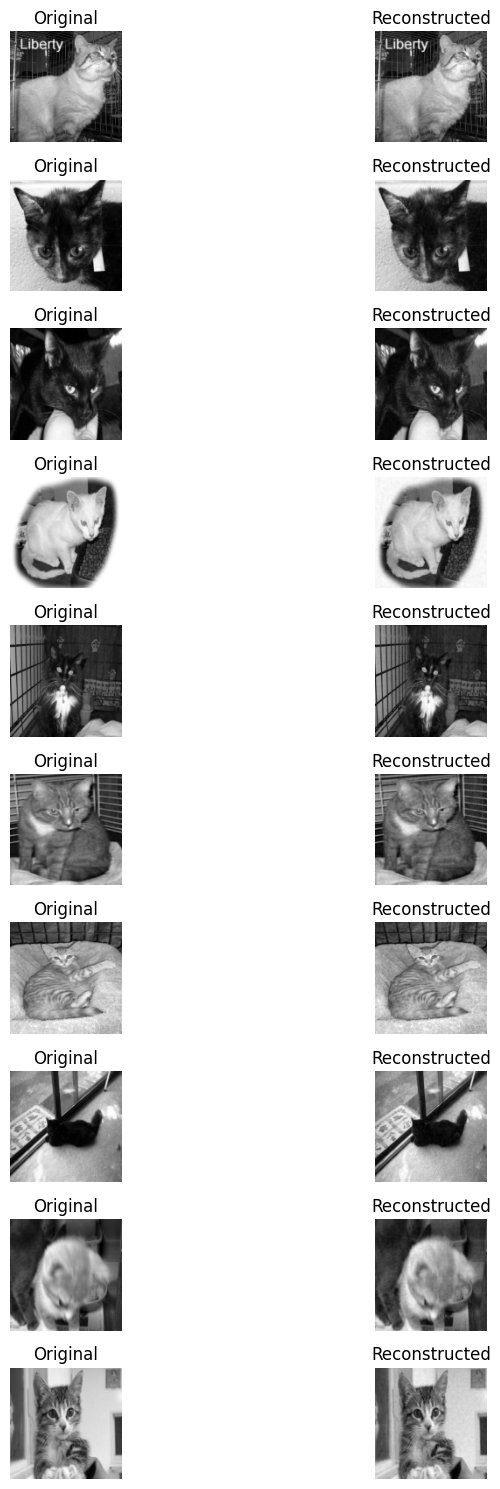

In [6]:
num_images_to_plot = 10
selected_images = train_images[:num_images_to_plot]
selected_flattened_images = flattened_train_images[:num_images_to_plot]
reconstructed_images = pca.inverse_transform(pca.transform(selected_flattened_images))
fig, axes = plt.subplots(num_images_to_plot, 2, figsize=(10, 15))
for i in range(num_images_to_plot):
    # Plot original images
    axes[i, 0].imshow(selected_images[i], cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original')

    # Reshape the reconstructed image to its original shape before plotting
    reconstructed_image_reshaped = reconstructed_images[i].reshape(selected_images[i].shape)

    # Plot reconstructed images
    axes[i, 1].imshow(reconstructed_image_reshaped, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Reconstructed')

plt.tight_layout()
plt.show()


**3.1 Use PCA to reduce dimensionality to only 2 dimensions.**

In [7]:
pca = PCA(n_components=2)
%time X_2d_pca = pca.fit_transform(X_train)

explained_variance_pca = np.sum(pca.explained_variance_ratio_)
print("Variance explained by the first two principal components:", explained_variance_pca)

CPU times: user 1.58 s, sys: 205 ms, total: 1.78 s
Wall time: 969 ms
Variance explained by the first two principal components: 0.31293502007942053


**3.2 Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image category. Then add some images to the visualization to better understand what features in the images are accounting for the majority of variance in the data**

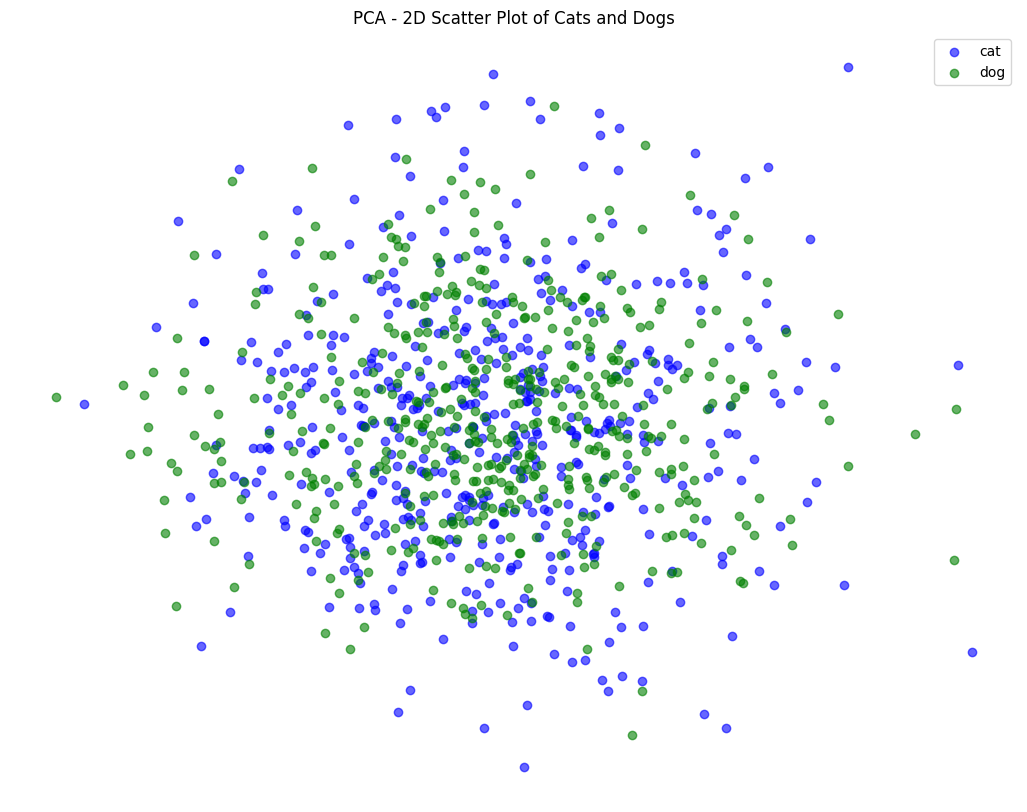

In [8]:
categories = np.array(['cat'] * len(train_images_cats) + ['dog'] * len(train_images_dogs))
category_colors = {'cat': 'blue', 'dog': 'green'}

# Concatenate all training images
all_train_images = np.concatenate((train_images_cats, train_images_dogs))
all_flattened_train_images = np.vstack([img.flatten() for img in all_train_images])

# Apply PCA to all training images
scaler = StandardScaler()
X_train_all = scaler.fit_transform(all_flattened_train_images)
pca = PCA(n_components=2)
images_pca_2d = pca.fit_transform(X_train_all)

# Scatter plot with PCA
plt.figure(figsize=(13, 10))
for category, color in category_colors.items():
    ix = np.where(categories == category)
    plt.scatter(images_pca_2d[ix, 0], images_pca_2d[ix, 1], c=color, label=category, alpha=0.6)
plt.title('PCA - 2D Scatter Plot of Cats and Dogs')
plt.axis("off")
plt.legend()
plt.show()




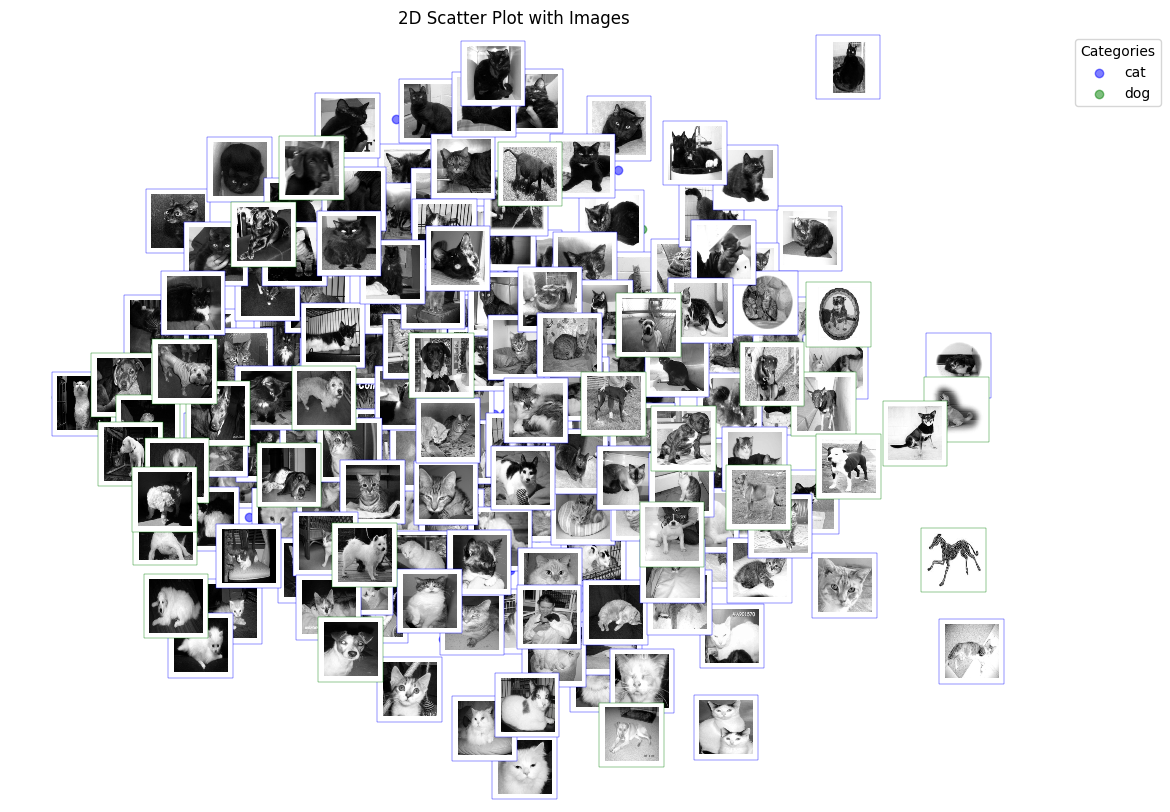

In [9]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_cd(X, categories, images=None, min_distance=0.04, figsize=(13, 10), image_zoom=0.1):
    # Normalize the features to range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)

    # Define colors for each category
    category_colors = {
        'cat': 'blue',
        'dog': 'green'
    }

    fig, ax = plt.subplots(figsize=figsize)

    for category in np.unique(categories):
        ax.scatter(X_normalized[categories == category, 0],
                   X_normalized[categories == category, 1],
                   c=category_colors[category], label=category, alpha=0.5)

    plt.axis("off")

    # Adding images with colored frame based on the category
    neighbors = np.array([[10., 10.]])
    for index, image_coord in enumerate(X_normalized):
        category = categories[index]
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is not None:
                image = images[index].reshape(128, 128)  # Assuming original image size is 128x128
                imagebox = AnnotationBbox(OffsetImage(image, zoom=image_zoom, cmap="gray"),
                                          image_coord, frameon=True,
                                          bboxprops=dict(edgecolor=category_colors[category], linewidth=0.3))
                ax.add_artist(imagebox)

    plt.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('2D Scatter Plot with Images')
    plt.show()

# Assuming images_pca_2d, categories, and all_train_images are available from previous code snippets
plot_cd(X=images_pca_2d, categories=categories, images=all_train_images, image_zoom=0.3)


**3.2 With t-sne**

In [10]:

tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data to 2D space
%time X_2d_tsne = tsne.fit_transform(X_train)


CPU times: user 17.5 s, sys: 382 ms, total: 17.9 s
Wall time: 10.4 s


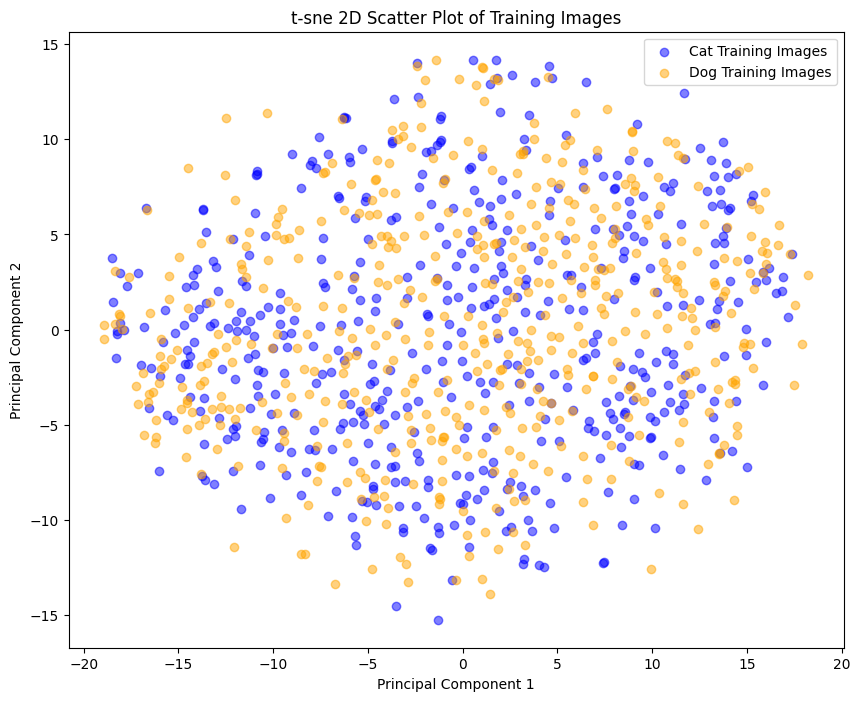

In [11]:

# Create a scatter plot
plt.figure(figsize=(10, 8))

# Plot training images
plt.scatter(X_2d_tsne[:len(flattened_train_images_cats), 0],
            X_2d_tsne[:len(flattened_train_images_cats), 1],
            color='blue', label='Cat Training Images', alpha=0.5)

plt.scatter(X_2d_tsne[len(flattened_train_images_dogs):, 0],
            X_2d_tsne[len(flattened_train_images_dogs):, 1],
            color='orange', label='Dog Training Images', alpha=0.5)
plt.title('t-sne 2D Scatter Plot of Training Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

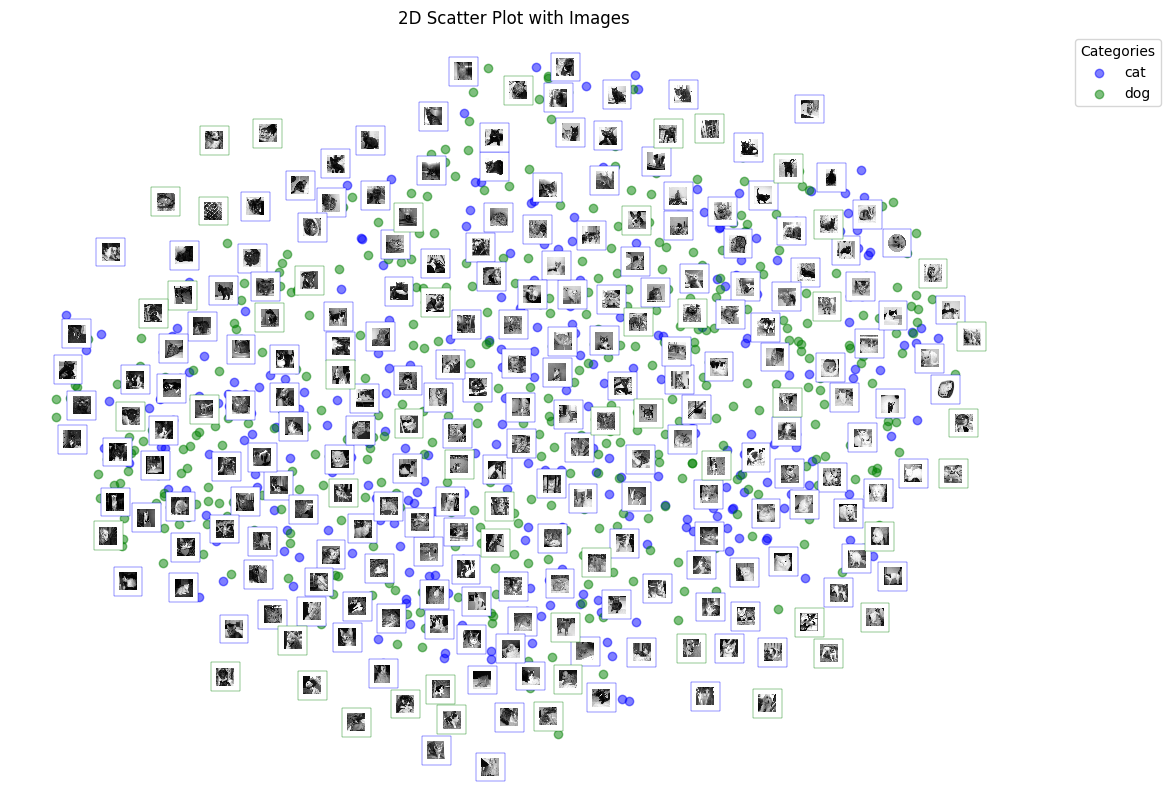

In [12]:
plot_cd(X=X_2d_tsne, categories=categories, images=all_train_images, image_zoom=0.1)

**3.2 With LLE**

In [13]:

# Create an LLE model with 2 components
lle = LocallyLinearEmbedding(n_components=2, random_state=42)

# Fit and transform the data to 2D space
%time X_2d_lle = lle.fit_transform(X_train)

CPU times: user 2.35 s, sys: 103 ms, total: 2.46 s
Wall time: 1.49 s


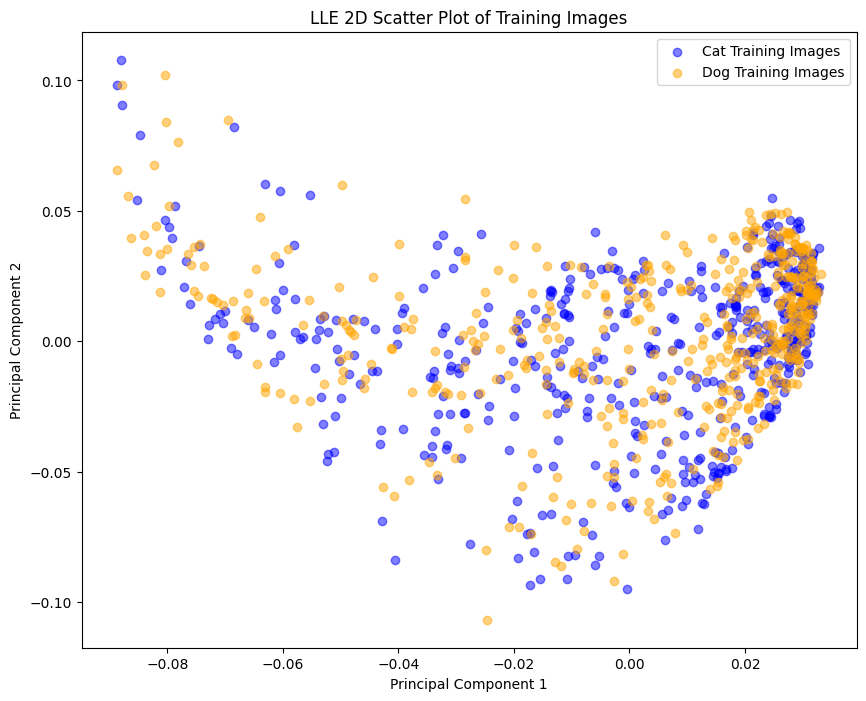

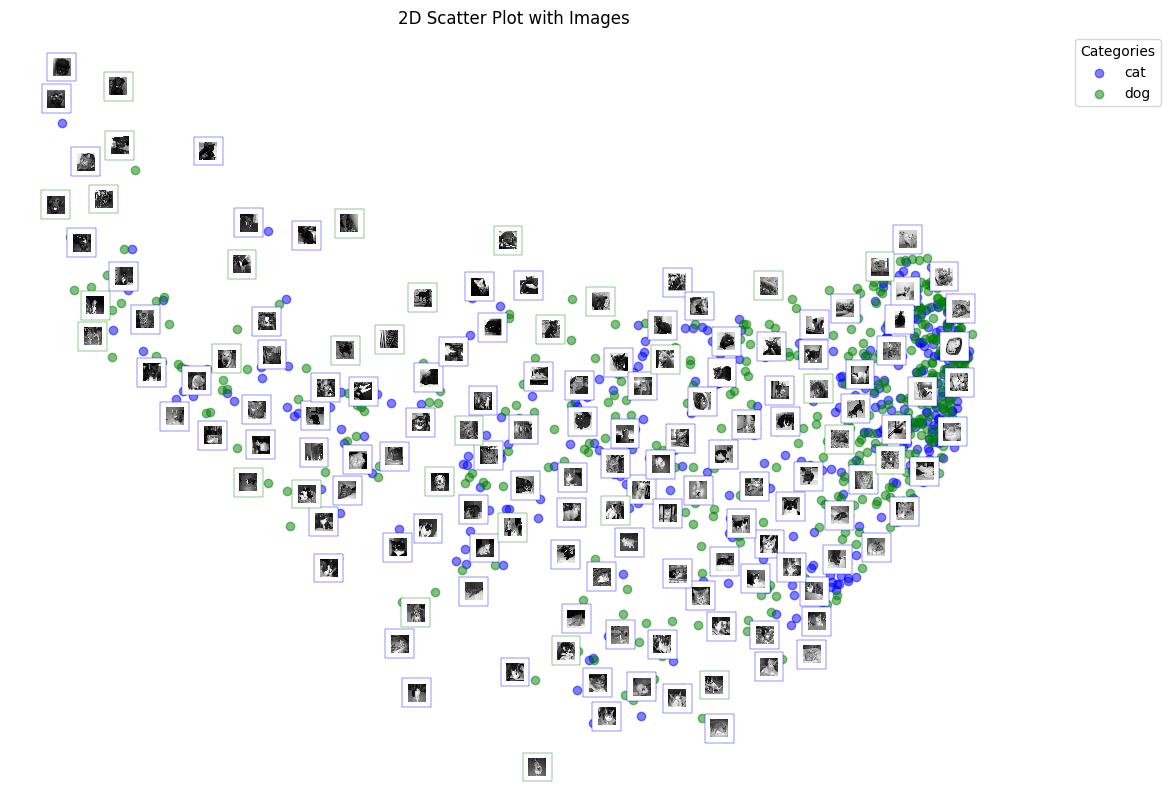

In [14]:
# Create a scatter plot
plt.figure(figsize=(10, 8))

# Plot training images
plt.scatter(X_2d_lle[:len(flattened_train_images_cats), 0],
            X_2d_lle[:len(flattened_train_images_cats), 1],
            color='blue', label='Cat Training Images', alpha=0.5)

plt.scatter(X_2d_lle[len(flattened_train_images_dogs):, 0],
            X_2d_lle[len(flattened_train_images_dogs):, 1],
            color='orange', label='Dog Training Images', alpha=0.5)
plt.title('LLE 2D Scatter Plot of Training Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
plot_cd(X=X_2d_lle, categories=categories, images=all_train_images, image_zoom=0.1)

**3.2 With mds**

In [15]:


# Create an MDS model with 2 components
mds = MDS(n_components=2, random_state=42)

# Fit and transform the data to 2D space
%time X_2d_mds = mds.fit_transform(X_train)

CPU times: user 22 s, sys: 13 s, total: 35 s
Wall time: 21.9 s


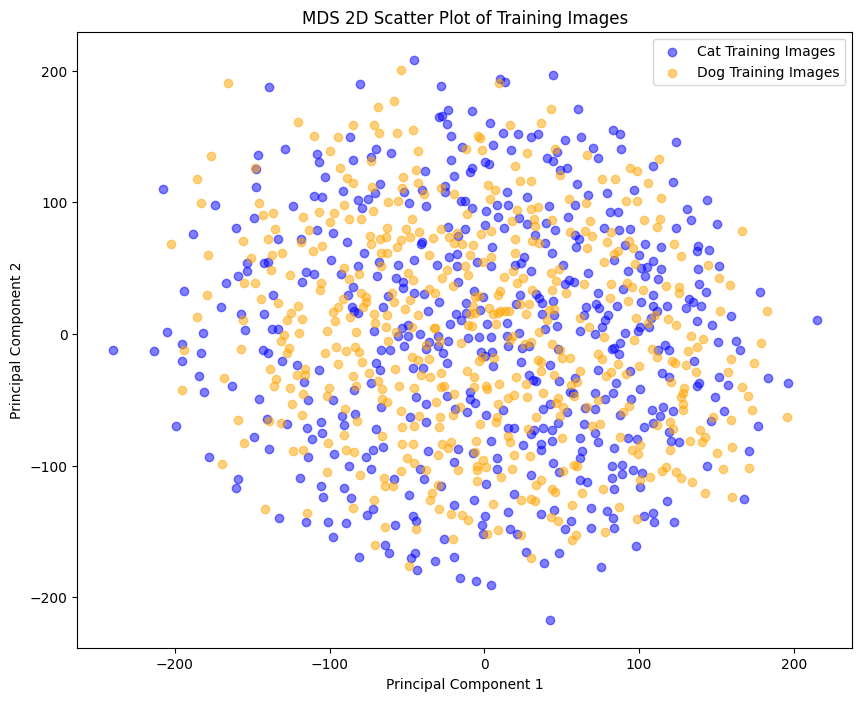

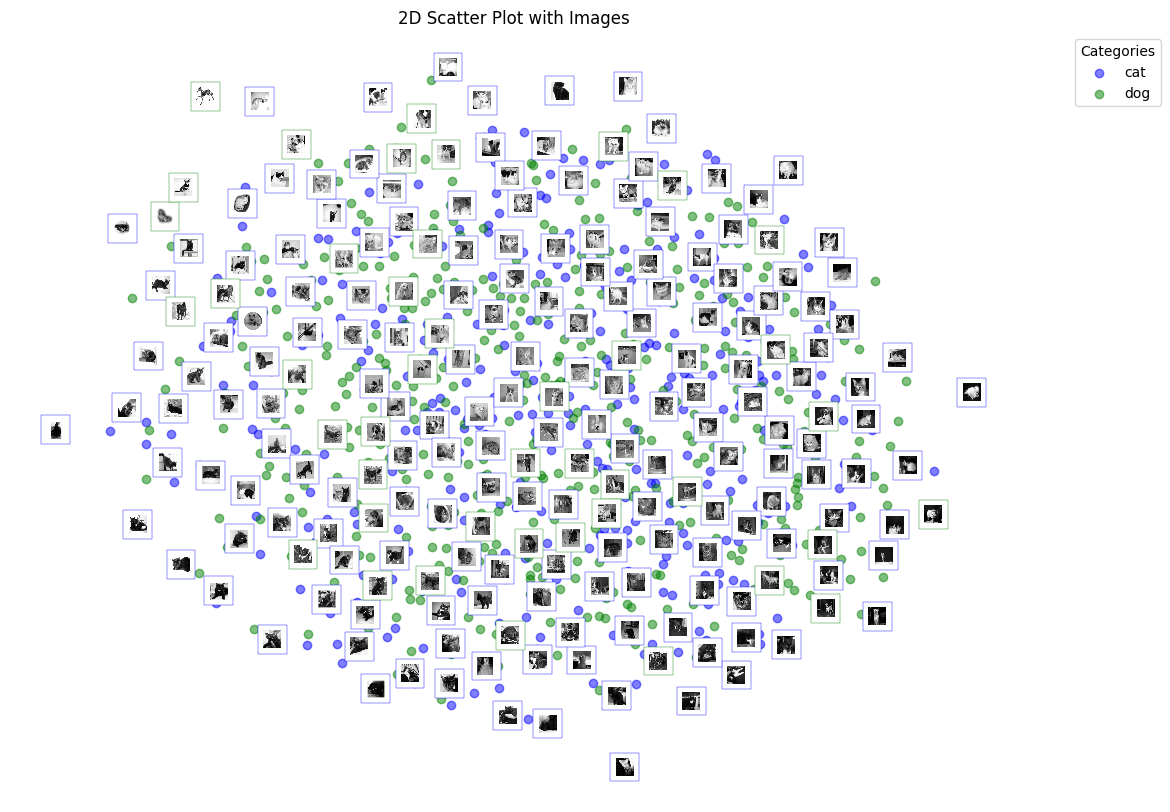

In [16]:

# Create a scatter plot
plt.figure(figsize=(10, 8))

# Plot training images
plt.scatter(X_2d_mds[:len(flattened_train_images_cats), 0],
            X_2d_mds[:len(flattened_train_images_cats), 1],
            color='blue', label='Cat Training Images', alpha=0.5)

plt.scatter(X_2d_mds[len(flattened_train_images_dogs):, 0],
            X_2d_mds[len(flattened_train_images_dogs):, 1],
            color='orange', label='Dog Training Images', alpha=0.5)
plt.title('MDS 2D Scatter Plot of Training Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
plot_cd(X=X_2d_mds, categories=categories, images=all_train_images, image_zoom=0.1)



Based on the provided scatter plots, here are my observations:

PCA - 2D Scatter Plot of Cats and Dogs:

The data points for cats and dogs appear somewhat overlapped, suggesting that the features used for PCA may not be providing clear separation between the two classes.
However, there seems to be a slightly higher concentration of green dots (dogs) towards the center and blue dots (cats) more spread out.

t-SNE 2D Scatter Plot of Training Images:

The t-SNE plot shows a better separation between the two classes compared to the PCA plot.
The cat and dog data points form distinct clusters, though there is still some overlap between the two groups.

2D Scatter Plot with Images:

This plot displays the actual images at their respective data point locations.
There is a clear separation between the two classes, with cats forming a distinct cluster on the left and dogs on the right.
The plot suggests that the underlying features used for this projection can effectively distinguish between cats and dogs.

MDS 2D Scatter Plot of Training Images:

The MDS plot exhibits a more scattered distribution of data points for both classes.
While there is some separation between cats and dogs, the overlap between the two groups is more pronounced compared to the t-SNE plot.

Overall, the t-SNE and image scatter plots seem to provide the best separation between cats and dogs, indicating that the features used in these projections are more effective in distinguishing the two classes. The PCA and MDS plots show more overlap, suggesting that additional or different features may be required for better class separation using these techniques.



**5.Cluster the images using K-Means.**

**A. Reduce the dimensionality using PCA, keep at least 90% of the variance.**

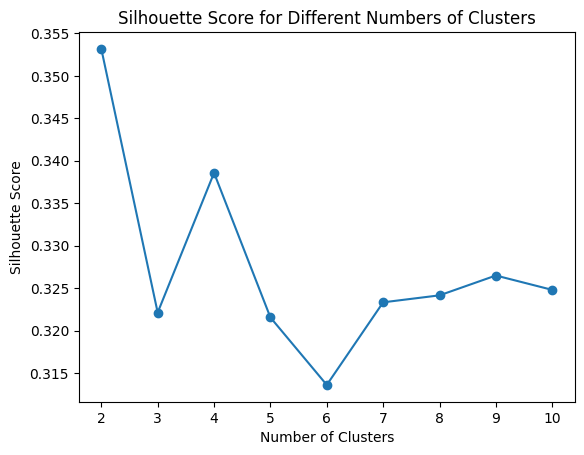

Optimal number of clusters: 2


In [17]:
silhouette_scores = []
possible_cluster_range = range(2, 11)  # You can adjust the range based on your needs

for n_clusters in possible_cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_2d_pca)
    silhouette_avg = silhouette_score(X_2d_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores to help determine the optimal number of clusters
plt.plot(possible_cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Choose the optimal number of clusters based on the plot or other criteria
optimal_num_clusters = possible_cluster_range[np.argmax(silhouette_scores)]
print(f'Optimal number of clusters: {optimal_num_clusters}')

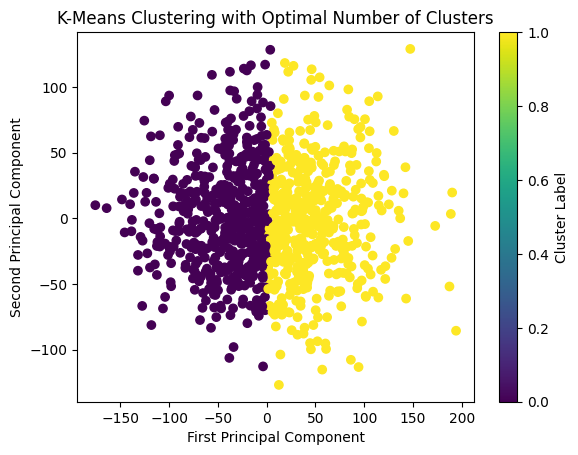

In [18]:
from sklearn.cluster import KMeans


kmeans_optimal = KMeans(n_clusters=optimal_num_clusters, random_state=42)
cluster_labels_optimal = kmeans_optimal.fit_predict(X_2d_pca)

# Visualize the clustering results (optional)
# You can use this code to visualize the clustering if desired
# Make sure to replace X_2d_pca with your PCA-transformed data
plt.scatter(X_2d_pca[:, 0], X_2d_pca[:, 1], c=cluster_labels_optimal, cmap='viridis')
plt.title('K-Means Clustering with Optimal Number of Clusters')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Cluster Label')
plt.show()


B. Set the number of clusters to 2 and report clustering accuracy.

Getting true labels

In [19]:
import os
import numpy as np
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Define the folder paths for cats and dogs
train_path_cats = '/content/archive/training_set/training_set/cats'
train_path_dogs = '/content/archive/training_set/training_set/dogs'

# Define the number of images to load
num_images = 500

# Define the target shape for resizing
target_shape = (128, 128)  # Adjust this based on your requirements

# Function to load and preprocess images from a folder
def load_and_preprocess_images(folder_path, label):
    images = []
    for file_name in os.listdir(folder_path)[:num_images]:
        if file_name.endswith('.jpg'):
            image_path = os.path.join(folder_path, file_name)
            img = io.imread(image_path)
            img_resized = resize(img, target_shape, anti_aliasing=True)
            img_flattened = img_resized.flatten()
            images.append(img_flattened)
    return images, [label] * len(images)

# Load and preprocess images for cats
train_images_cats, labels_cats = load_and_preprocess_images(train_path_cats, 'cat')

# Load and preprocess images for dogs
train_images_dogs, labels_dogs = load_and_preprocess_images(train_path_dogs, 'dog')

# Combine the images and labels as lists
train_images = train_images_cats + train_images_dogs
categories = np.array(labels_cats + labels_dogs)

# Convert the combined lists of images into NumPy arrays
train_images = np.array(train_images)

# Apply StandardScaler for feature scaling
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images)


In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Perform K-Means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(train_images_scaled)

# Convert cluster labels to match the ground truth labels
# Assuming 'categories' variable contains the ground truth labels
predicted_labels = np.array(['cat', 'dog'])[cluster_labels]

# Calculate clustering accuracy
accuracy = accuracy_score(categories, predicted_labels)
print("Clustering accuracy:", accuracy)


Clustering accuracy: 0.492


**6.Cluster the images using EM.**

**You can again reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance.**

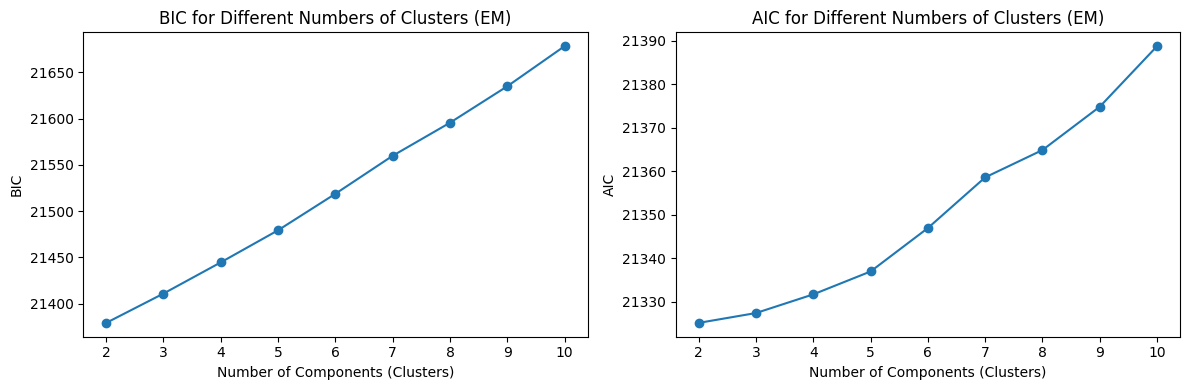

Optimal number of components using BIC: 2
Optimal number of components using AIC: 2


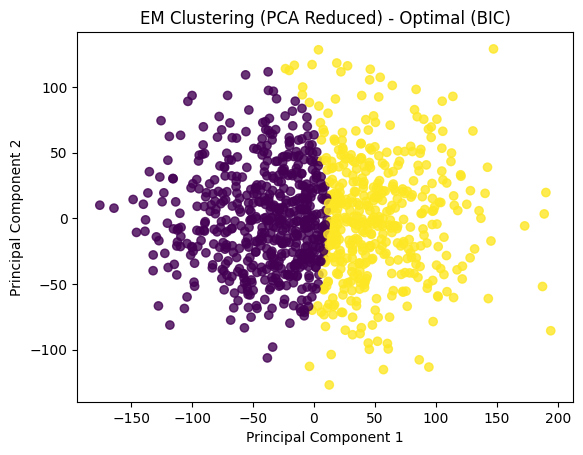

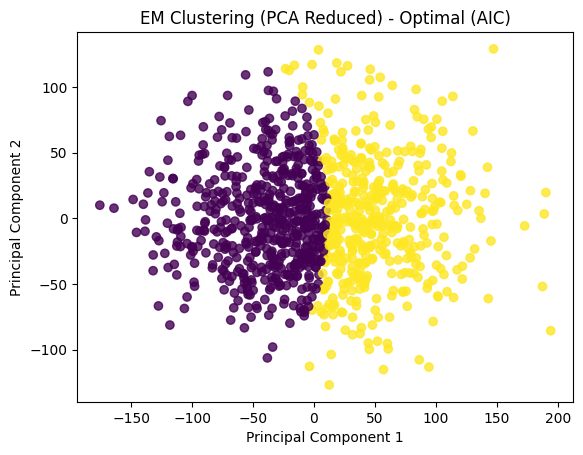

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Assuming X_2d_pca contains the 2D PCA reduced data

# Determine the number of clusters using BIC and AIC
bic_scores = []
aic_scores = []
possible_cluster_range = range(2, 11)  # You can adjust the range based on your needs

for n_components in possible_cluster_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_2d_pca)
    bic_scores.append(gmm.bic(X_2d_pca))
    aic_scores.append(gmm.aic(X_2d_pca))

# Plot BIC and AIC scores to help determine the optimal number of clusters
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(possible_cluster_range, bic_scores, marker='o')
plt.title('BIC for Different Numbers of Clusters (EM)')
plt.xlabel('Number of Components (Clusters)')
plt.ylabel('BIC')

plt.subplot(1, 2, 2)
plt.plot(possible_cluster_range, aic_scores, marker='o')
plt.title('AIC for Different Numbers of Clusters (EM)')
plt.xlabel('Number of Components (Clusters)')
plt.ylabel('AIC')

plt.tight_layout()
plt.show()

# Choose the optimal number of components (clusters) based on BIC or AIC
optimal_num_components_bic = possible_cluster_range[np.argmin(bic_scores)]
optimal_num_components_aic = possible_cluster_range[np.argmin(aic_scores)]

print(f'Optimal number of components using BIC: {optimal_num_components_bic}')
print(f'Optimal number of components using AIC: {optimal_num_components_aic}')

# Perform EM clustering with the optimal number of components (BIC)
gmm_optimal_bic = GaussianMixture(n_components=optimal_num_components_bic, random_state=42)
cluster_labels_optimal_bic = gmm_optimal_bic.fit_predict(X_2d_pca)

# Perform EM clustering with the optimal number of components (AIC)
gmm_optimal_aic = GaussianMixture(n_components=optimal_num_components_aic, random_state=42)
cluster_labels_optimal_aic = gmm_optimal_aic.fit_predict(X_2d_pca)

# Visualize the clusters in 2D for BIC
plt.scatter(X_2d_pca[:, 0], X_2d_pca[:, 1], c=cluster_labels_optimal_bic, cmap='viridis', alpha=0.8)
plt.title('EM Clustering (PCA Reduced) - Optimal (BIC)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Visualize the clusters in 2D for AIC
plt.scatter(X_2d_pca[:, 0], X_2d_pca[:, 1], c=cluster_labels_optimal_aic, cmap='viridis', alpha=0.8)
plt.title('EM Clustering (PCA Reduced) - Optimal (AIC)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


**B.Set the number of clusters to 2 and report clustering accuracy**

In [22]:
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_predict = gmm.fit_predict(X_2d_pca)

silhouette_avg_gmm = silhouette_score(X_2d_pca, gmm_predict)
print("The average silhouette_score is :", silhouette_avg_gmm)

The average silhouette_score is : 0.31319568476530757


**6.Use the model to generate 20 new images (using the sample() method), and visualize them in the original image space (since you used PCA, you will need to use its inverse_transform() method).**

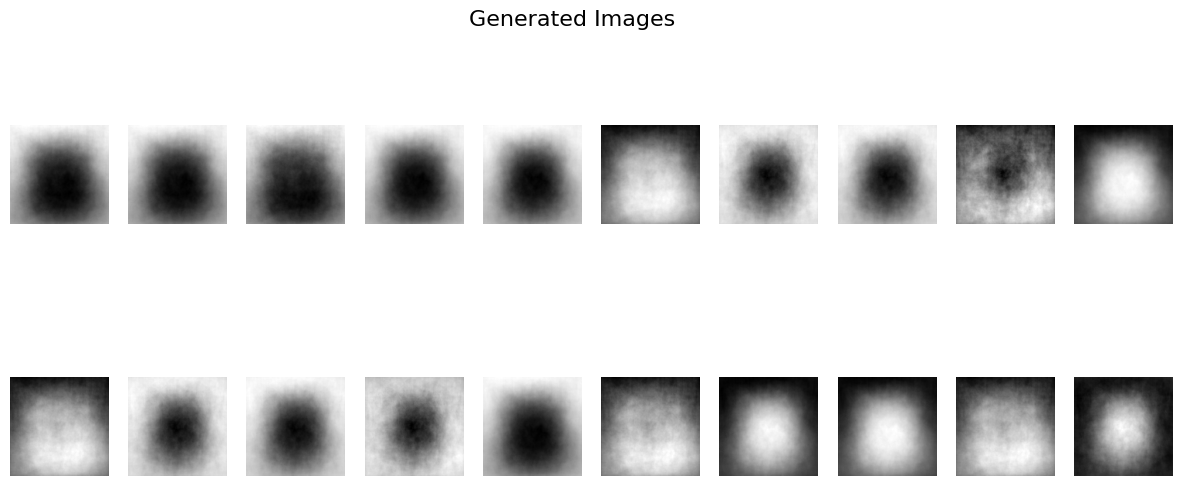

In [24]:
import os
import numpy as np
from skimage import io, transform, color
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load and preprocess images
train_path_cats = '/content/archive/training_set/training_set/cats'
num_images = 500
images = []
for file_name in os.listdir(train_path_cats)[:num_images]:
    if file_name.endswith('.jpg'):
        image_path = os.path.join(train_path_cats, file_name)
        img = io.imread(image_path)
        if len(img.shape) == 3:  # Check if the image is RGB
            img = color.rgb2gray(img)
        img = transform.resize(img, (128, 128))
        images.append(img)

# Convert images to a numpy array
images_array = np.array(images)

# Assuming X_2d_pca contains the 2D PCA reduced data
# Assuming you have determined the optimal number of components for GMM
optimal_num_components = 3  # Change this based on your analysis

# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_num_components, random_state=42)
gmm.fit(X_2d_pca)

# Generate 20 new samples in PCA space
new_samples_pca = gmm.sample(20)[0]  # Extract samples from the tuple

# Use inverse_transform to map the generated samples back to the original space
new_samples_original_space = pca.inverse_transform(new_samples_pca)

# Reshape the flattened images to their original shape
new_samples_images = new_samples_original_space.reshape(-1, images_array.shape[1], images_array.shape[2])

# Visualize the generated images
plt.figure(figsize=(15, 6))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(new_samples_images[i], cmap='gray')
    plt.axis('off')

plt.suptitle('Generated Images', fontsize=16)
plt.show()


**7.1 Build a feedforward neural network (using dense and/or CNN layers) with a few hidden layers (we suggest using Keras (within Tensorflow) or Pytorch).**

In [25]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

# Number of images to use for training and validation
num_train_images = 500
num_validation_images = 250

# Directory containing all the images
image_dir = '/content/archive/training_set/training_set'  # Replace with the actual path to your image directory

# List all image filenames in the directory
image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Extract class labels from the first letter of the filenames
class_labels = [filename[0] for filename in image_filenames]
image_paths = [os.path.join(image_dir, filename) for filename in image_filenames]

# Use a subset of the images for training
train_image_paths = image_paths[:num_train_images]
train_class_labels = class_labels[:num_train_images]

# Use a subset of the images for validation
validation_dir = '/content/archive/test_set/test_set'  # Replace with the actual path to your validation directory
validation_image_filenames = [f for f in os.listdir(validation_dir) if f.endswith('.jpg')]
validation_image_paths = [os.path.join(validation_dir, filename) for filename in validation_image_filenames][:num_validation_images]
validation_class_labels = [filename[0] for filename in validation_image_filenames][:num_validation_images]

# Set up data generator for training
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    subset='training'
)

# Set up data generator for validation
validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Build the neural network model
model = keras.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='softmax')  # Use 'sigmoid' for binary classification
    ]
)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Compile and train the model
start_time = time.time()
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    steps_per_epoch=num_train_images // 32,
    validation_steps=num_validation_images // 32
)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")
# Rest of the code for evaluation and visualization


Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Epoch 1/10
15/15 [==============================] - 19s 830ms/step - loss: 0.9445 - accuracy: 0.5146 - val_loss: 0.6747 - val_accuracy: 0.5446
Epoch 2/10
15/15 [==============================] - 11s 735ms/step - loss: 0.6841 - accuracy: 0.5063 - val_loss: 0.6702 - val_accuracy: 0.4911
Epoch 3/10
15/15 [==============================] - 11s 739ms/step - loss: 0.6763 - accuracy: 0.4708 - val_loss: 0.6641 - val_accuracy: 0.4777
Epoch 4/10
15/15 [==============================] - 12s 831ms/step - loss: 0.6752 - accuracy: 0.4688 - val_loss: 0.6789 - val_accuracy: 0.5134
Epoch 5/10
15/15 [==============================] - 12s 837ms/step - loss: 0.6753 - accuracy: 0.4812 - val_loss: 0.6451 - val_accuracy: 0.4375
Epoch 6/10
15/15 [==============================] - 11s 755ms/step - loss: 0.6410 - accuracy: 0.5083 - val_loss: 0.6941 - val_accuracy: 0.4955
Epoch 7/10
15/15 [==============================] - 12s 83

Training time: 155.64051723480225 seconds

**7.2. Plot training and validation loss and accuracy as a function of training epochs.**

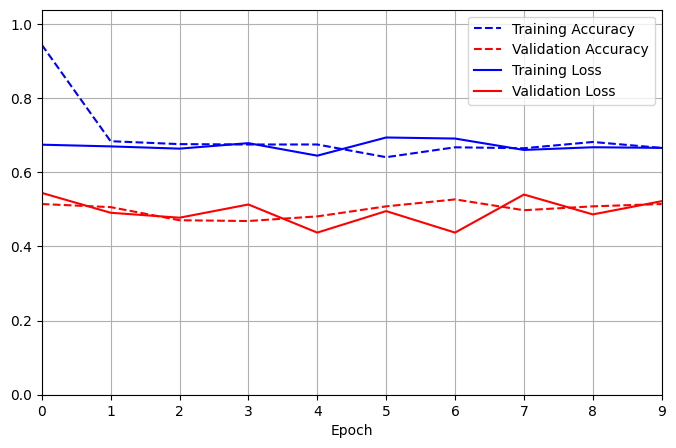

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame from the history dictionary
history_df = pd.DataFrame(history.history)

# Plotting
history_df.plot(figsize=(8, 5),
                xlim=[0, len(history_df)-1],  # Dynamic x-axis limit based on epochs
                ylim=[0, max(history_df.max())*1.1],  # Dynamic y-axis limit based on data range
                grid=True,
                xlabel="Epoch",
                style={"accuracy": "r--", "val_accuracy": "r-", "loss": "b--", "val_loss": "b-"})

# Adjusting the legend
plt.legend(["Training Accuracy", "Validation Accuracy", "Training Loss", "Validation Loss"], loc="best")
plt.show()


**7.3 How many parameters does the network have? How many of those parameters are bias parameters?**

In [27]:
total_params = model.count_params()
bias_params = sum([np.prod(p.shape) for p in model.trainable_weights if 'bias' in p.name])

print(f"Total parameters: {total_params}")
print(f"Bias parameters: {bias_params}")


Total parameters: 22244929
Bias parameters: 481
